In [253]:
import numpy as np
import matplotlib.pyplot as plt
from utils import \
    compute_edges, find_parallel, plot_line, initial_points, \
    plot_ruler, compute_grad, lines_mask, compute_score, compute_dp, compute_pan, compute_rot, compute_spring

# 1. Image Loading

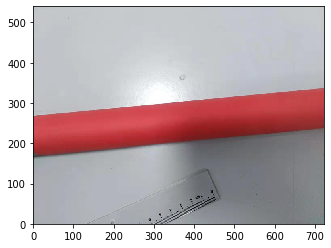

In [254]:
img = plt.imread("data/3.jpg")
img = img[::2,::2]
h, w = np.shape(img)[:2]

plt.imshow(img, extent=(0,w,0,h))

# 2. Hough Transform

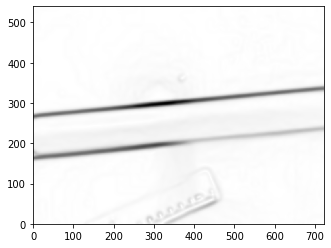

In [255]:
edges = compute_edges(img,5)

plt.imshow(edges, extent=(0,w,0,h),cmap='Greys')

(0, 540)

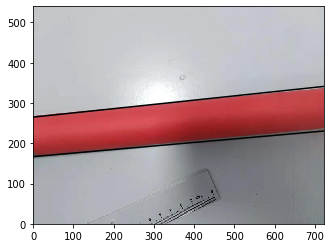

In [256]:
# todo 此处可以考虑用低分辨率图像以减少霍夫变换的计算量
(theta1, rho1), (theta2, rho2) = find_parallel(edges)

plt.imshow(img, extent=(0,w,0,h))
plot_line(plt,w,h,theta1,rho1)
plot_line(plt,w,h,theta2,rho2)
plt.xlim(0,w)
plt.ylim(0,h)

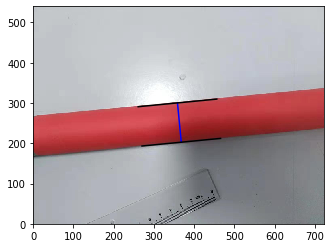

In [257]:
(x1,y1),(x2,y2) = initial_points(theta1,rho1,theta2,rho2,w,h)

p1 = np.array((x1,h-y1))
p2 = np.array((x2,h-y2))

plt.imshow(img, extent=(0,w,0,h))
plot_ruler(plt,p1,p2)

# 3. Gradient Decent

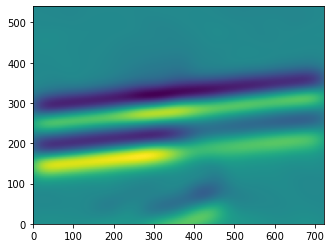

In [258]:
grad = compute_grad(edges,25)

plt.imshow(grad[...,1], extent=(0,w,0,h))

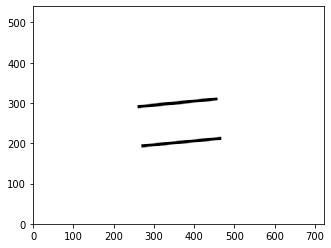

In [259]:
ps = np.stack(np.meshgrid(np.arange(w),np.flip(np.arange(h))),-1)

line1, line2 = lines_mask(p1,p2,ps,thickness=5)
plt.imshow(line1+line2+grad[...,1], extent=(0,w,0,h),cmap="Greys")

(0, 540)

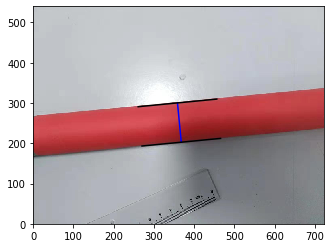

In [260]:
v1 = 0
v2 = 0

scores = []
movements = []

plt.imshow(img, extent=(0,w,0,h))
plot_ruler(plt,p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

step=1, movement=0.29, score=6.01
step=2, movement=0.49, score=6.01
step=3, movement=0.62, score=6.01
step=4, movement=0.69, score=6.00
step=5, movement=0.73, score=5.98
step=6, movement=0.75, score=5.95
step=7, movement=0.75, score=5.91
step=8, movement=0.75, score=5.86
step=9, movement=0.75, score=5.81
step=10, movement=0.75, score=5.76


(0, 540)

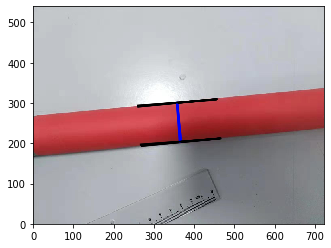

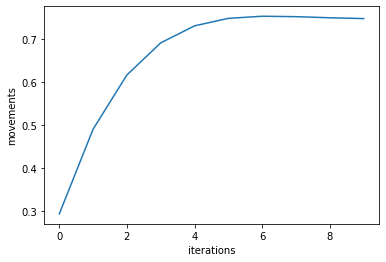

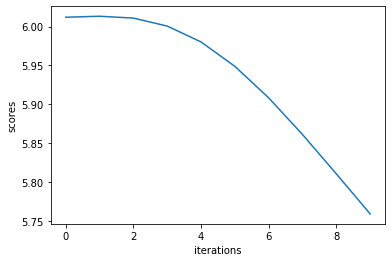

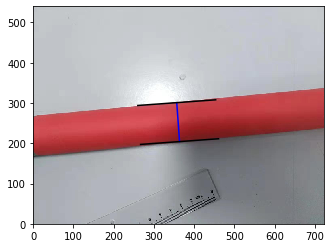

In [261]:
decent_rate = 1.0
momentum = 1
damping = 0.3

length = np.sqrt(w*h)
thickness = 5
expand = 1

pan_m = 0.0002*length*(thickness+expand)
rot_m = 0.01*length*length*(thickness+expand)
spr_m = 0.1*length

plt.figure()
plt.imshow(img, extent=(0,w,0,h))
plot_ruler(plt,p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

for i in range(10):
    
    mask1, mask2 = lines_mask(p1, p2, ps, thickness, expand)
    mask_all = mask1 + mask2
    
    dp1 = 0
    dp2 = 0
    
    dp1_pan = compute_pan(grad, mask1)
    dp2_pan = compute_pan(grad, mask2)
    dp1 += dp1_pan / pan_m
    dp2 += dp2_pan / pan_m
    
    dp1_rot, dp2_rot = compute_rot(p1, p2, ps, grad, mask_all)
    dp1 += dp1_rot / rot_m
    dp2 += dp2_rot / rot_m
    
    dp1_spr, dp2_spr = compute_spring(p1, p2, 50,150,10)
    dp1 += dp1_spr / spr_m
    dp2 += dp2_spr / spr_m
    
    v1 += dp1*decent_rate/momentum
    v2 += dp2*decent_rate/momentum
    
    v1 *= 1.0-damping
    v2 *= 1.0-damping
    
    p1 += v1
    p2 += v2
    
    movement = np.sqrt(np.sum(np.square(v1))) + np.sqrt(np.sum(np.square(v2)))
    movements.append(movement)
    
    score = compute_score(mask_all,edges)*(10**4)
    # score = compute_score(mask_all,edges)
    scores.append(score)
    
    print(f"step={len(movements)}, movement={movement:.2f}, score={score:.2f}")
    plot_ruler(plt,p1,p2)
    
    if len(movements)>5:
        if movements[-1]<0.5:
            last_movements = np.array(movements[-5:])
            mean = np.mean(last_movements)
            std_dev = np.sqrt(np.mean(np.square(last_movements-mean)))
            if std_dev/mean <= 0.01:
                break

plt.figure()
plt.plot(movements)
plt.ylabel("movements")
plt.xlabel("iterations")

plt.figure()
plt.plot(scores)
plt.ylabel("scores")
plt.xlabel("iterations")

plt.figure()
plt.imshow(img, extent=(0,w,0,h))
plot_ruler(plt,p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)